In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
data, info = tfds.load('cifar10', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [ ]:
data

[<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
len(data[0])

50000

In [ ]:
def split_dataset(data, train_size=0.8, test_size=0.1, val_size=0.1):
  size = len(data)
  train = data.take(int(size * train_size))
  rest = data.skip(int(size * train_size))
  test = rest.take(int(size * test_size))
  val = rest.skip((int(size * test_size)))

  return train, test, val

In [ ]:
train_dataset, test_dataset, val_dataset = split_dataset(data[0])

In [ ]:
list(train_dataset.take(1))

[(<tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
  array([[[143,  96,  70],
          [141,  96,  72],
          [135,  93,  72],
          ...,
          [ 96,  37,  19],
          [105,  42,  18],
          [104,  38,  20]],
  
         [[128,  98,  92],
          [146, 118, 112],
          [170, 145, 138],
          ...,
          [108,  45,  26],
          [112,  44,  24],
          [112,  41,  22]],
  
         [[ 93,  69,  75],
          [118,  96, 101],
          [179, 160, 162],
          ...,
          [128,  68,  47],
          [125,  61,  42],
          [122,  59,  39]],
  
         ...,
  
         [[187, 150, 123],
          [184, 148, 123],
          [179, 142, 121],
          ...,
          [198, 163, 132],
          [201, 166, 135],
          [207, 174, 143]],
  
         [[187, 150, 117],
          [181, 143, 115],
          [175, 136, 113],
          ...,
          [201, 164, 132],
          [205, 168, 135],
          [207, 171, 139]],
  
         [[195, 161, 126]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

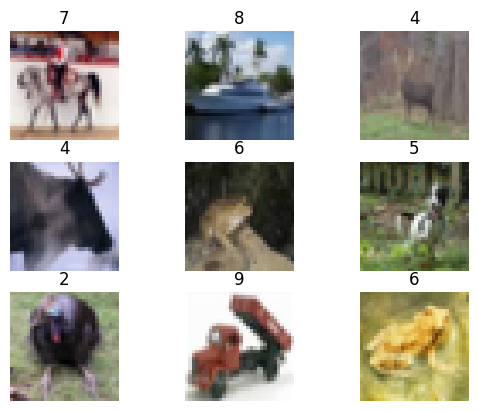

In [ ]:
for i, (img, label) in enumerate(train_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.axis('off')
  plt.title(str(label.numpy()))
  plt.imshow(img);


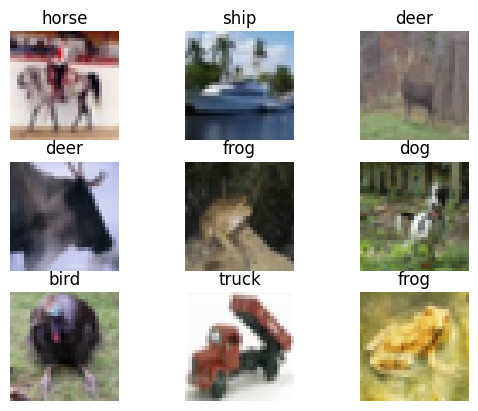

In [ ]:
for i, (img, label) in enumerate(train_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.axis('off')
  plt.title(info.features['label'].int2str(label))
  plt.imshow(img);


In [ ]:
IM_SIZE = 112

def resize_rescale(img, label):
  return tf.image.resize(img, (IM_SIZE, IM_SIZE)) / 255.0, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)

In [ ]:
list(train_dataset.take(1))

[(<tf.Tensor: shape=(112, 112, 3), dtype=float32, numpy=
  array([[[0.56078434, 0.3764706 , 0.27450982],
          [0.56078434, 0.3764706 , 0.27450982],
          [0.5591036 , 0.3764706 , 0.2761905 ],
          ...,
          [0.40868348, 0.15238094, 0.0767507 ],
          [0.40784314, 0.14901961, 0.07843138],
          [0.40784314, 0.14901961, 0.07843138]],
  
         [[0.56078434, 0.3764706 , 0.27450982],
          [0.56078434, 0.3764706 , 0.27450982],
          [0.5591036 , 0.3764706 , 0.2761905 ],
          ...,
          [0.40868348, 0.15238094, 0.0767507 ],
          [0.40784314, 0.14901961, 0.07843138],
          [0.40784314, 0.14901961, 0.07843138]],
  
         [[0.54817927, 0.37815127, 0.2929972 ],
          [0.54817927, 0.37815127, 0.2929972 ],
          [0.5501    , 0.3817527 , 0.29791918],
          ...,
          [0.4152261 , 0.15472187, 0.07915166],
          [0.41456583, 0.1515406 , 0.08011205],
          [0.41456583, 0.1515406 , 0.08011205]],
  
         ...,
  
     

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=9, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=9, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=9, reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

In [ ]:
"""tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),








InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=10, kernel_size=3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')"""

"tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=x_train.shape[1:], activation='relu'),\n    tf.keras.layers.Conv2D(32, 3, activation='relu'),\n    tf.keras.layers.MaxPooling2D(),\n    tf.keras.layers.Dropout(0.25),\n\n    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),\n    tf.keras.layers.Conv2D(64, 3, activation='relu'),\n    tf.keras.layers.MaxPooling2D(),\n    tf.keras.layers.Dropout(0.25),\n\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dense(512, activation='relu'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(num_classes, activation='softmax'),\n\n\n\n\n\n\n\n\nInputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),\n    Conv2D(filters=6, kernel_size=3, strides=1, activation='relu'),\n    BatchNormalization(),\n    MaxPooling2D(pool_size=2, strides=2),\n    \n    Conv2D(filters=10, kernel_size=3, strides=1, activation='relu'),\n    BatchNormalization(),\n    MaxPooling2D(pool_size=2, strides=2),\n\n    Flatten(),\n\n    Dense(100, acti

In [ ]:
lenet_model = Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax'),

])

In [ ]:
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 55, 55, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 53, 53, 64)        36928     
                                                        

In [ ]:
lenet_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics='accuracy'
)

In [ ]:
hist = lenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1
)

Epoch 1/20
1250/1250 [==============================] - 65s 48ms/step - loss: 1.8343 - accuracy: 0.3391 - val_loss: 1.6388 - val_accuracy: 0.4100
Epoch 2/20
1250/1250 [==============================] - 50s 40ms/step - loss: 1.5486 - accuracy: 0.4455 - val_loss: 1.3662 - val_accuracy: 0.5240
Epoch 3/20
1250/1250 [==============================] - 51s 40ms/step - loss: 1.3828 - accuracy: 0.5080 - val_loss: 1.2473 - val_accuracy: 0.5588
Epoch 4/20
1250/1250 [==============================] - 49s 40ms/step - loss: 1.2530 - accuracy: 0.5558 - val_loss: 1.1672 - val_accuracy: 0.5896
Epoch 5/20
1250/1250 [==============================] - 50s 40ms/step - loss: 1.1572 - accuracy: 0.5929 - val_loss: 1.1087 - val_accuracy: 0.6096
Epoch 6/20
1250/1250 [==============================] - 50s 40ms/step - loss: 1.0866 - accuracy: 0.6190 - val_loss: 1.0661 - val_accuracy: 0.6248
Epoch 7/20
1250/1250 [==============================] - 51s 41ms/step - loss: 1.0217 - accuracy: 0.6427 - val_loss: 1.0480 -

In [ ]:
import pandas as pd

In [ ]:
h_df = pd.DataFrame(hist.history)

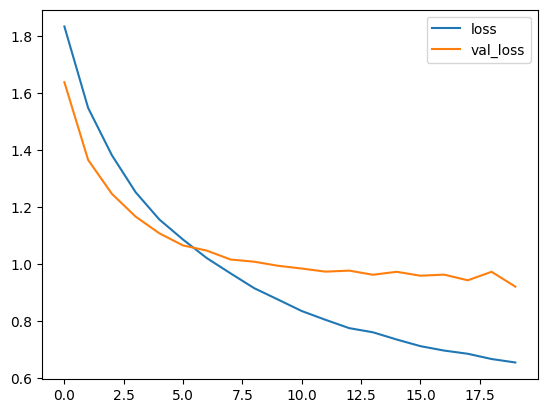

In [ ]:
h_df.loc[:, ['loss', 'val_loss']].plot();

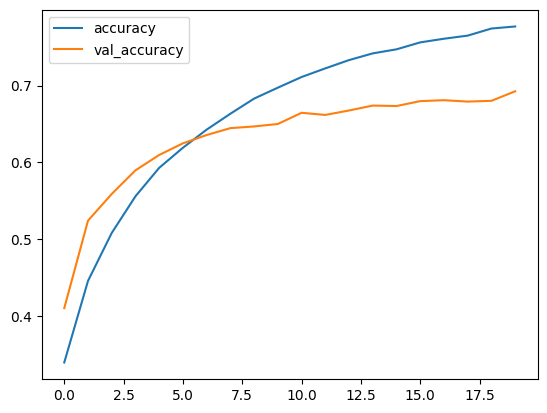

In [ ]:
h_df.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
lenet_model.evaluate(test_dataset)

5000/5000 [==============================] - 17s 3ms/step - loss: 0.9475 - accuracy: 0.6890


[0.9475263953208923, 0.6890000104904175]

In [ ]:
# NIIIIIIIIICE
# I did it on kitchen in the morning
# I have a low battery level on laptop
# BYE!!!!

<img src='https://media1.tenor.com/m/PpKrIUGnKecAAAAd/maxwell-run.gif'>